In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import glob
import re
import os
import seaborn as sns

In [12]:
# Define the directory containing the output files
output_dir = "outputs"  # adjust if your files are in a different directory

# Get a list of files that follow the expected naming pattern
file_pattern = os.path.join(output_dir, "i_*_k_*_a_*.txt")
file_list = glob.glob(file_pattern)


In [29]:
# Create a list to hold summary data for each file
data_list = []

# Iterate over each file and extract parameters from the filename
for file_path in file_list:
    base = os.path.basename(file_path)
    # Expected filename pattern: i_<input_file>_k_<k_value>_a_<a_value>.txt
    match = re.match(r"i_(.+)_k_([0-9]+)_a_([0-9\.]+)\.txt", base)
    if match:
        input_file, k_val, a_val = match.groups()
        # Handle cases like "01" for a = 0.01 (if a decimal point is missing)
        if '.' not in a_val and len(a_val) <= 2:
            a_val = "0." + a_val
        k_val = int(k_val)
        a_val = float(a_val)
        
        # Read the CSV file (assuming two comma-separated columns)
        df = pd.read_csv(file_path, header=None, names=["bps1", "bps2"])
        
        # Compute average bps values (you can also explore the distribution)
        avg_bps1 = df["bps1"].mean()
        avg_bps2 = df["bps2"].mean()
        
        # Append the summary information to our list
        data_list.append({
            "input_file": input_file,
            "k": k_val,
            "a": a_val,
            "avg_bps1": avg_bps1,
            "avg_bps2": avg_bps2
        })

# Create a DataFrame from the collected data
summary_df = pd.DataFrame(data_list)
print(summary_df)


       input_file   k     a  avg_bps1  avg_bps2
0   sequence1.txt  10  0.01  0.063019  0.056034
1   sequence1.txt  10  0.05  0.257417  0.251539
2   sequence1.txt  10  0.10  0.452308  0.447459
3   sequence1.txt  10  0.20  0.740443  0.736966
4   sequence1.txt  10  0.50  1.224010  1.222390
..            ...  ..   ...       ...       ...
95  sequence5.txt   5  0.01  0.907346  0.665953
96  sequence5.txt   5  0.05  1.206940  1.749257
97  sequence5.txt   5  0.10  1.430100  2.639230
98  sequence5.txt   5  0.20  1.715830  2.969907
99  sequence5.txt   5  0.50  2.180320  3.852347

[100 rows x 5 columns]


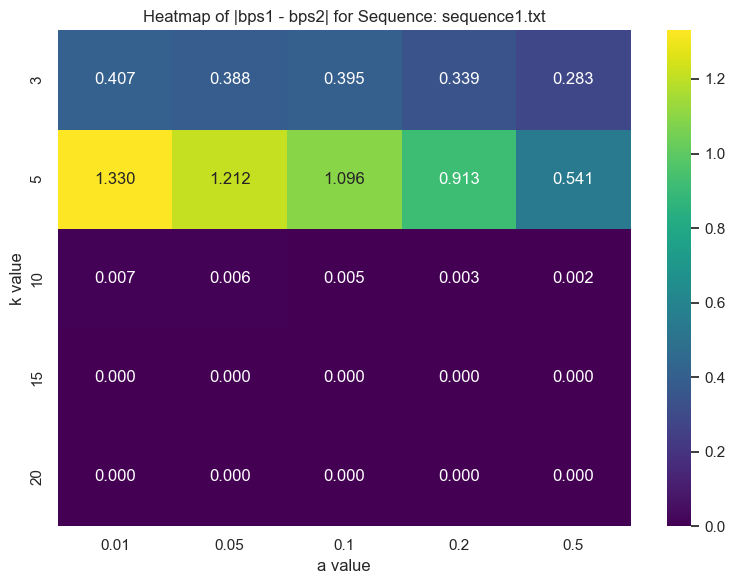

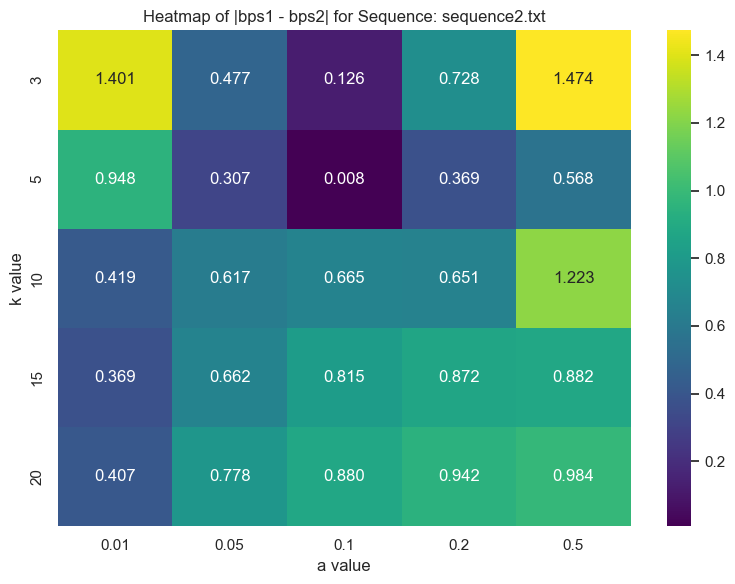

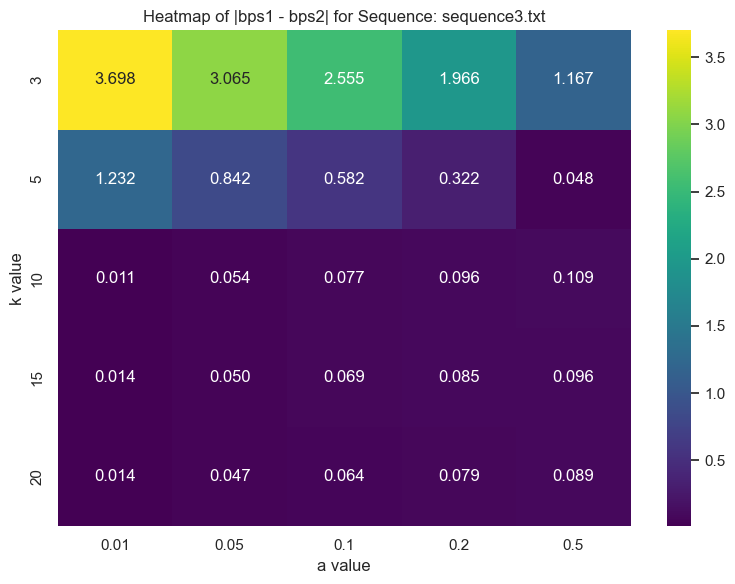

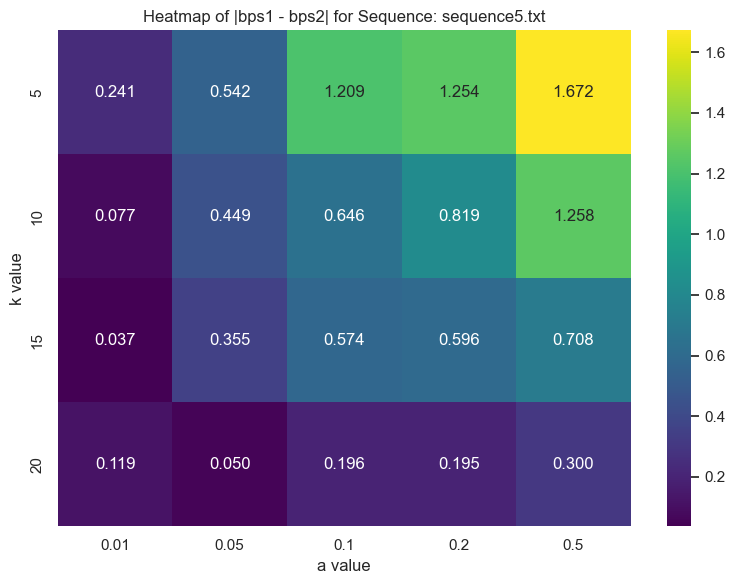

In [37]:
# Compute the absolute difference between bps1 and bps2
summary_df["diff"] = abs(summary_df["avg_bps1"] - summary_df["avg_bps2"])

# Create heatmaps for each sequence separately
unique_sequences = summary_df["input_file"].unique()
for seq in unique_sequences:
    seq_df = summary_df[summary_df["input_file"] == seq]
    # Create a pivot table with k as rows, a as columns and the mean difference as values
    pivot_data = seq_df.pivot_table(index="k", columns="a", values="diff", aggfunc="mean")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_data, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Heatmap of |bps1 - bps2| for Sequence: {seq}")
    plt.xlabel("a value")
    plt.ylabel("k value")
    plt.tight_layout()
    plt.show()

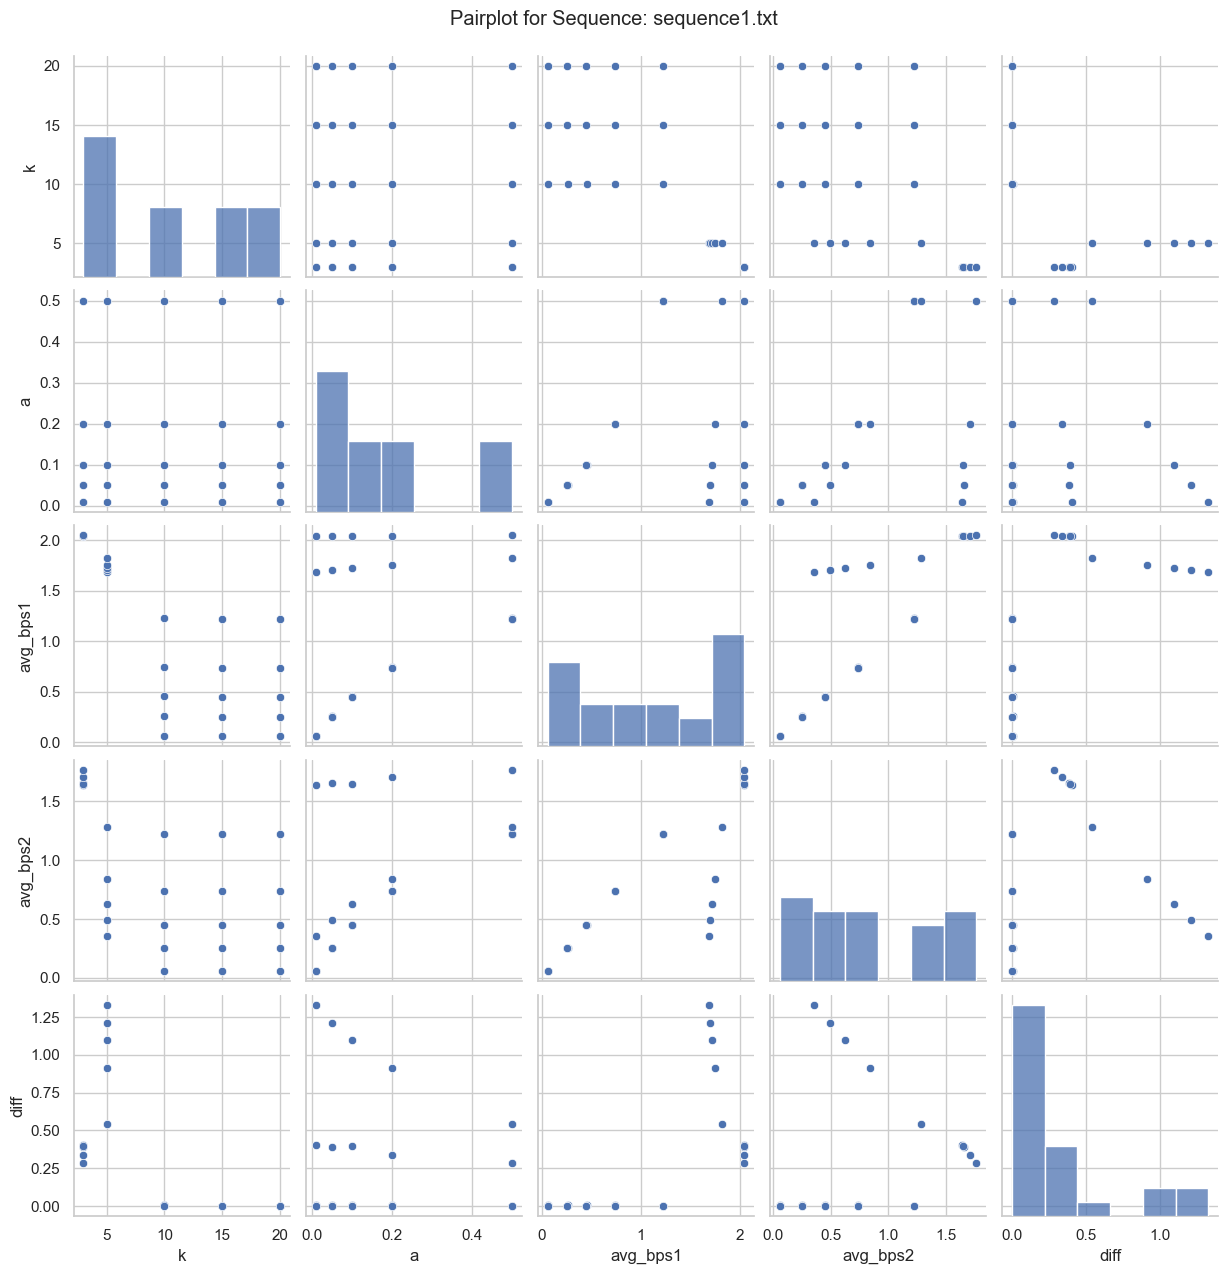

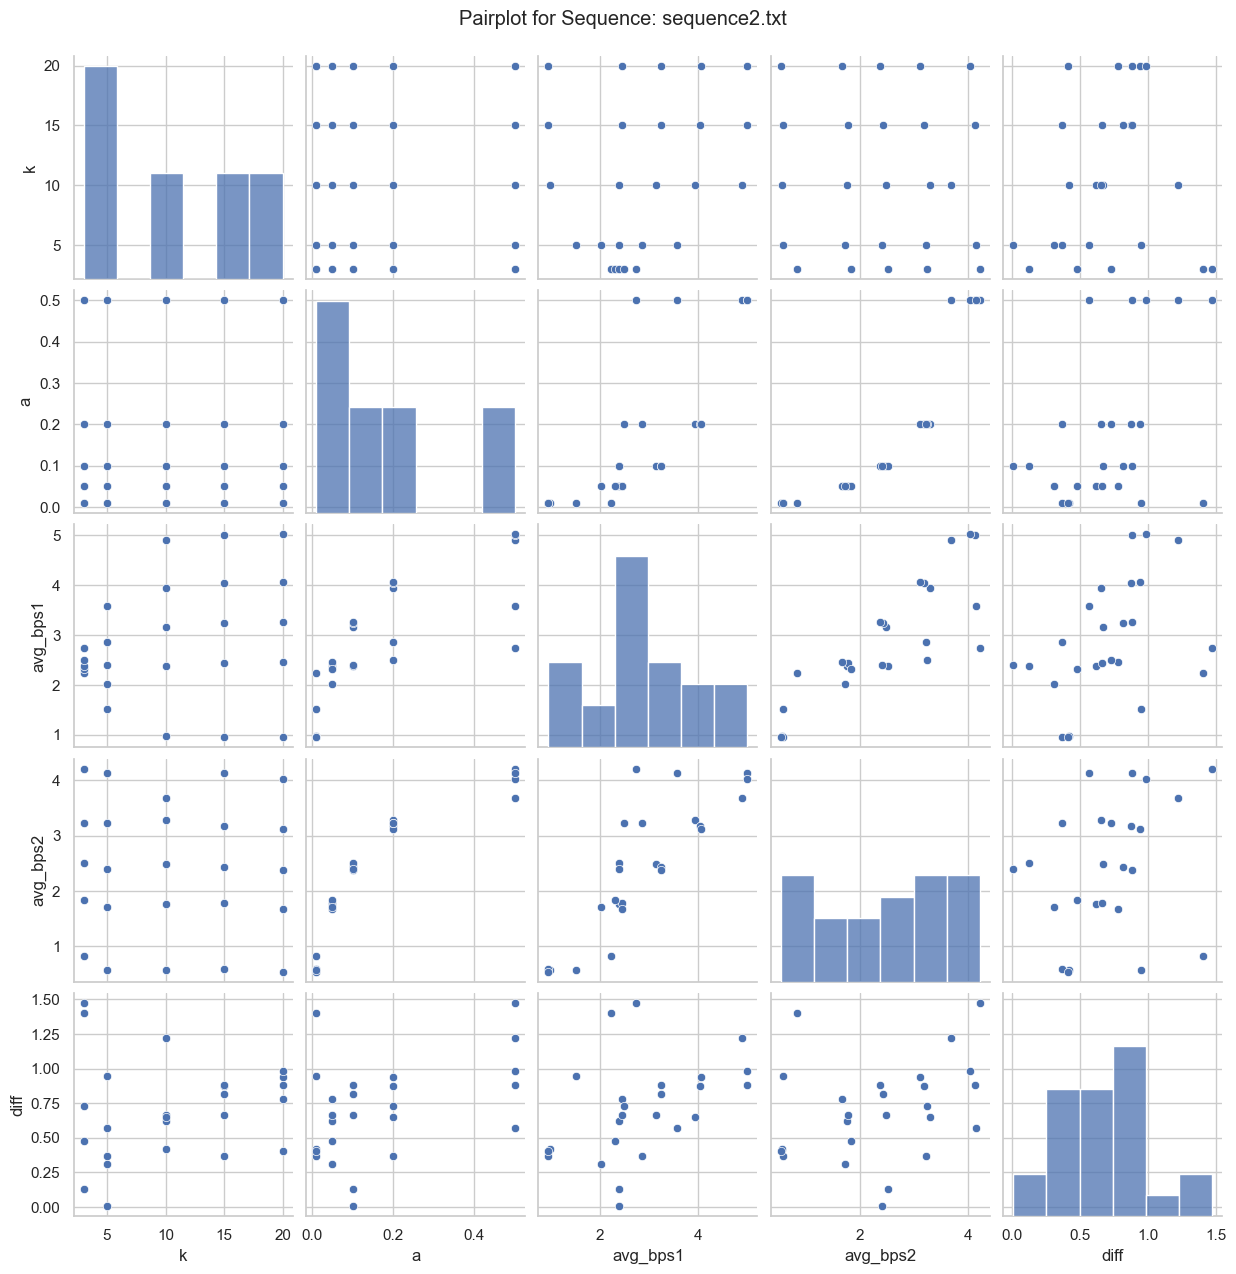

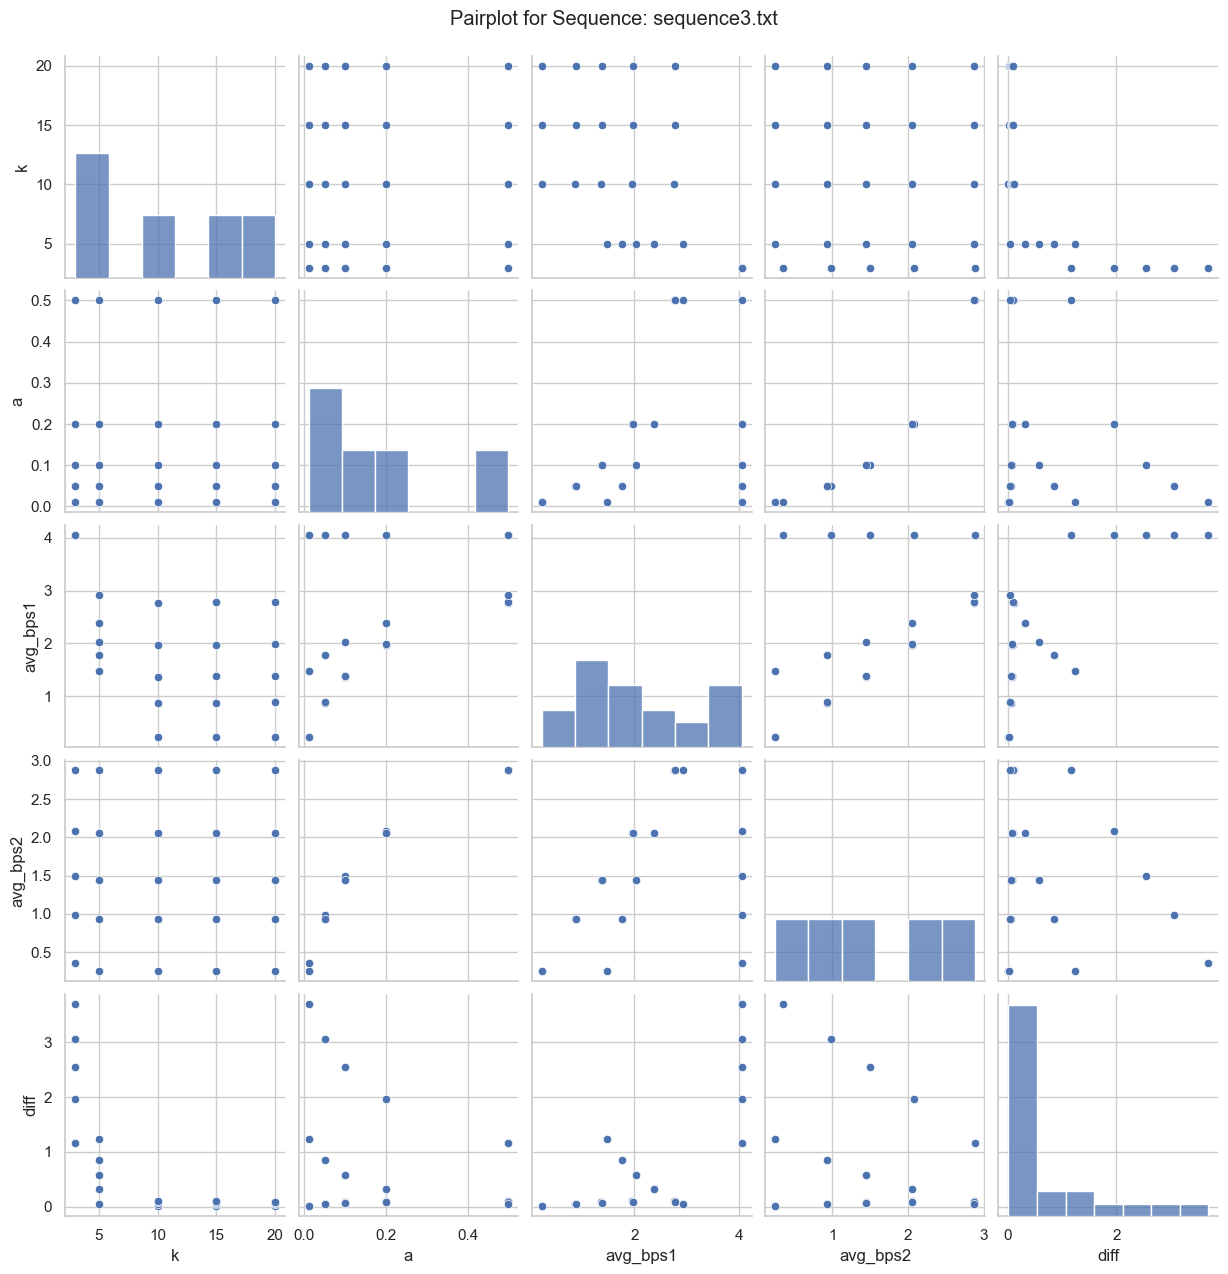

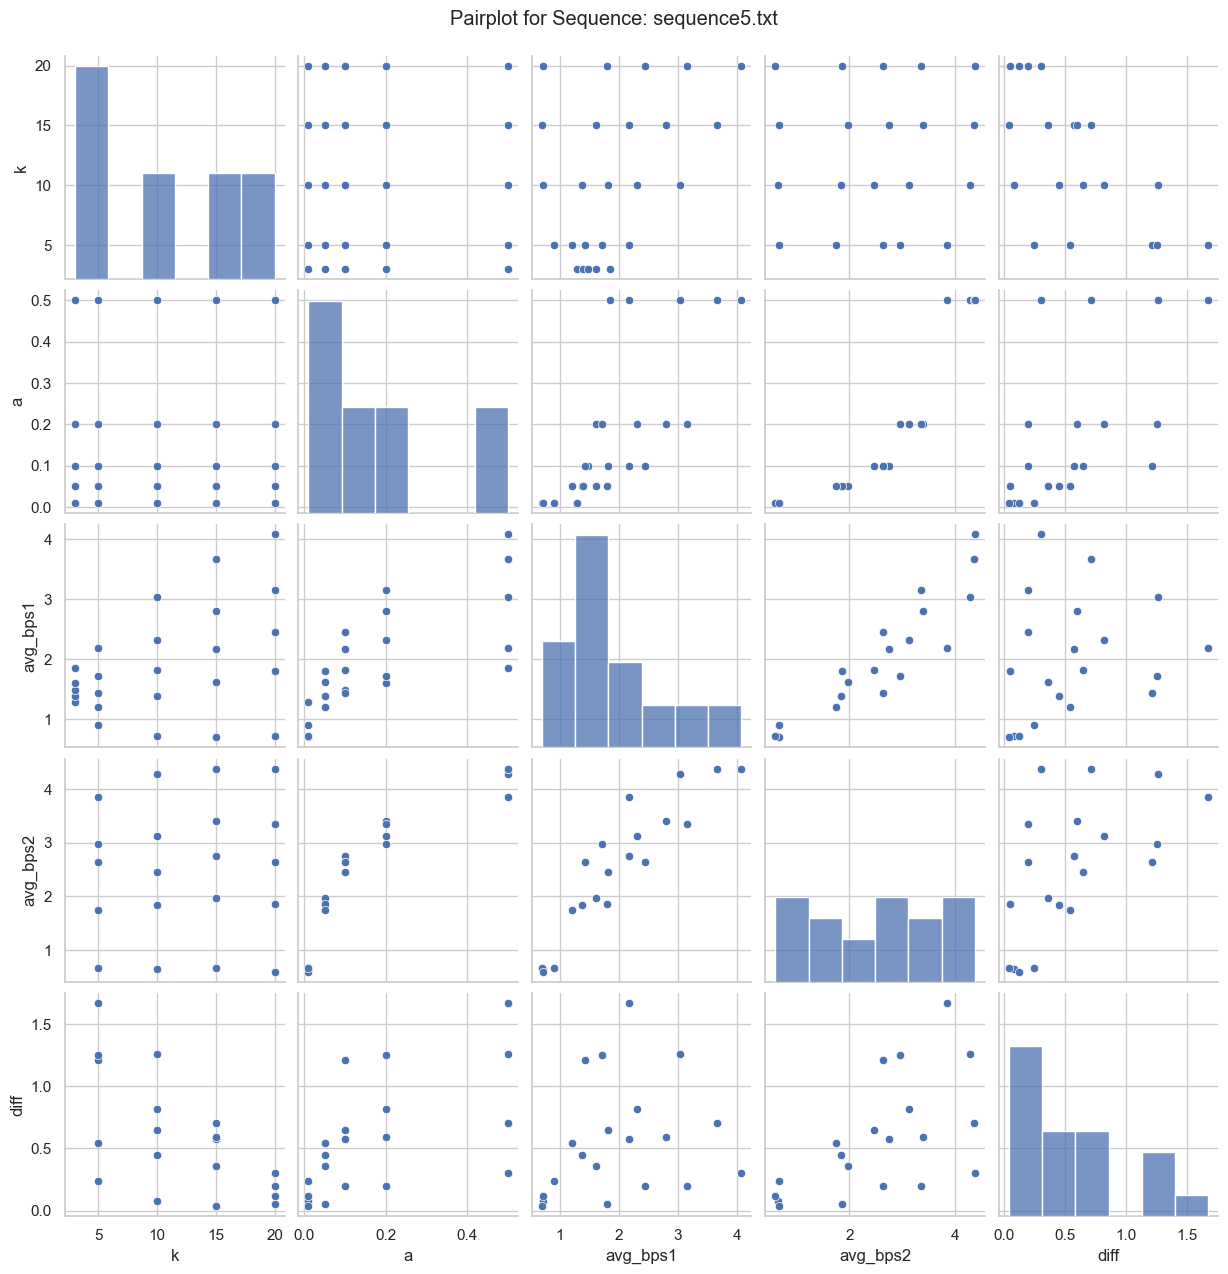

In [ ]:
# Option B: Parallel Coordinates Plot for each sequence
# (Note: Parallel coordinates require a 'class' column.
# Here, we use 'k' as a categorical class for illustration.)
for seq in summary_df["input_file"].unique():
    seq_data = summary_df[summary_df["input_file"] == seq].copy()
    # Convert k to string so it can be used as a class label
    seq_data["k_str"] = seq_data["k"].astype(str)
    plt.figure(figsize=(10,6))
    parallel_coordinates(seq_data[["k_str", "a", "avg_bps1", "avg_bps2", "diff"]].sort_values("a"),
                           class_column="k_str", colormap="viridis")
    plt.title(f"Parallel Coordinates Plot for Sequence: {seq}")
    plt.xlabel("Variables")
    plt.ylabel("Value")
    plt.legend(title="k value", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

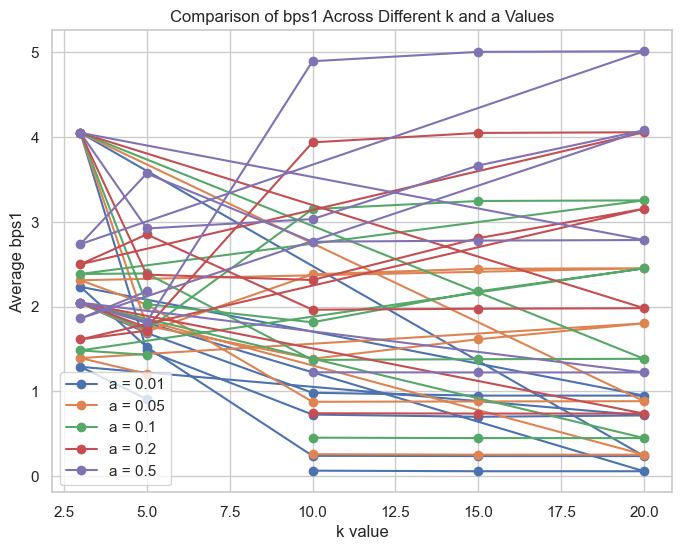

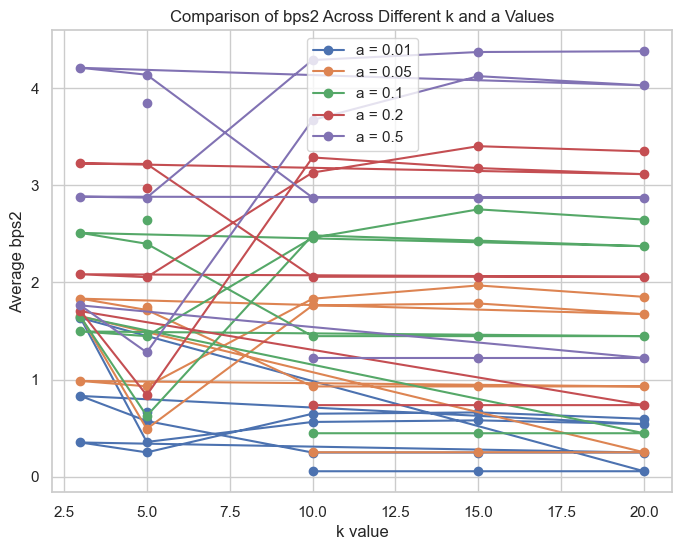

In [ ]:

# Plot average bps1 as a function of k for different a values
fig, ax = plt.subplots(figsize=(8,6))
for a_val in sorted(summary_df["a"].unique()):
    subset = summary_df[summary_df["a"] == a_val]
    ax.plot(subset["k"], subset["avg_bps1"], marker='o', label=f"a = {a_val}")
ax.set_xlabel("k value")
ax.set_ylabel("Average bps1")
ax.set_title("Comparison of bps1 Across Different k and a Values")
ax.legend()
plt.show()

# Similarly, you can create a plot for avg_bps2:
fig, ax = plt.subplots(figsize=(8,6))
for a_val in sorted(summary_df["a"].unique()):
    subset = summary_df[summary_df["a"] == a_val]
    ax.plot(subset["k"], subset["avg_bps2"], marker='o', label=f"a = {a_val}")
ax.set_xlabel("k value")
ax.set_ylabel("Average bps2")
ax.set_title("Comparison of bps2 Across Different k and a Values")
ax.legend()
plt.show()


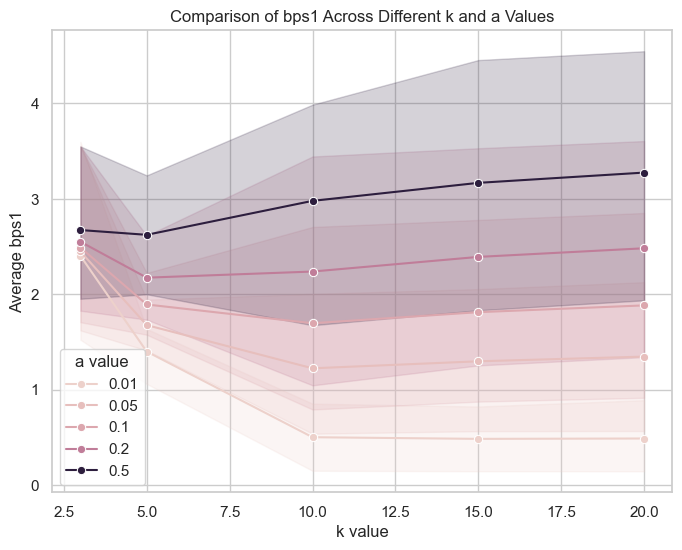

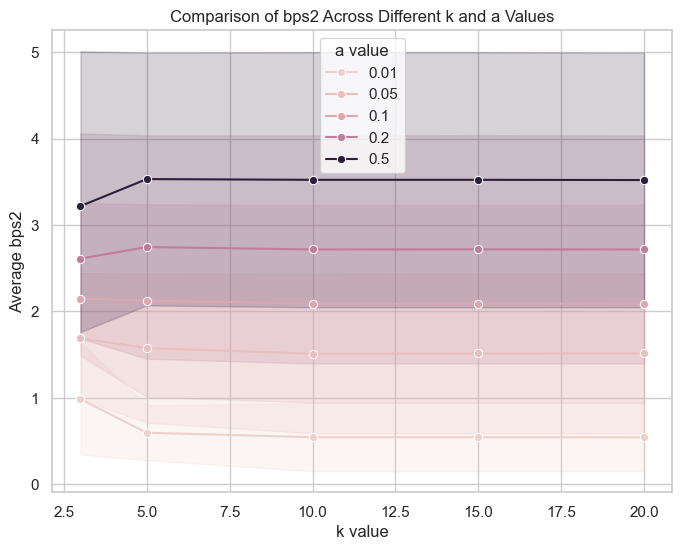

In [8]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plot average bps1 as a function of k for different a values using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=summary_df, x="k", y="avg_bps1", hue="a", marker="o")
plt.title("Comparison of bps1 Across Different k and a Values")
plt.xlabel("k value")
plt.ylabel("Average bps1")
plt.legend(title="a value")
plt.show()

# Plot average bps2 similarly
plt.figure(figsize=(8, 6))
sns.lineplot(data=summary_df, x="k", y="avg_bps2", hue="a", marker="o")
plt.title("Comparison of bps2 Across Different k and a Values")
plt.xlabel("k value")
plt.ylabel("Average bps2")
plt.legend(title="a value")
plt.show()

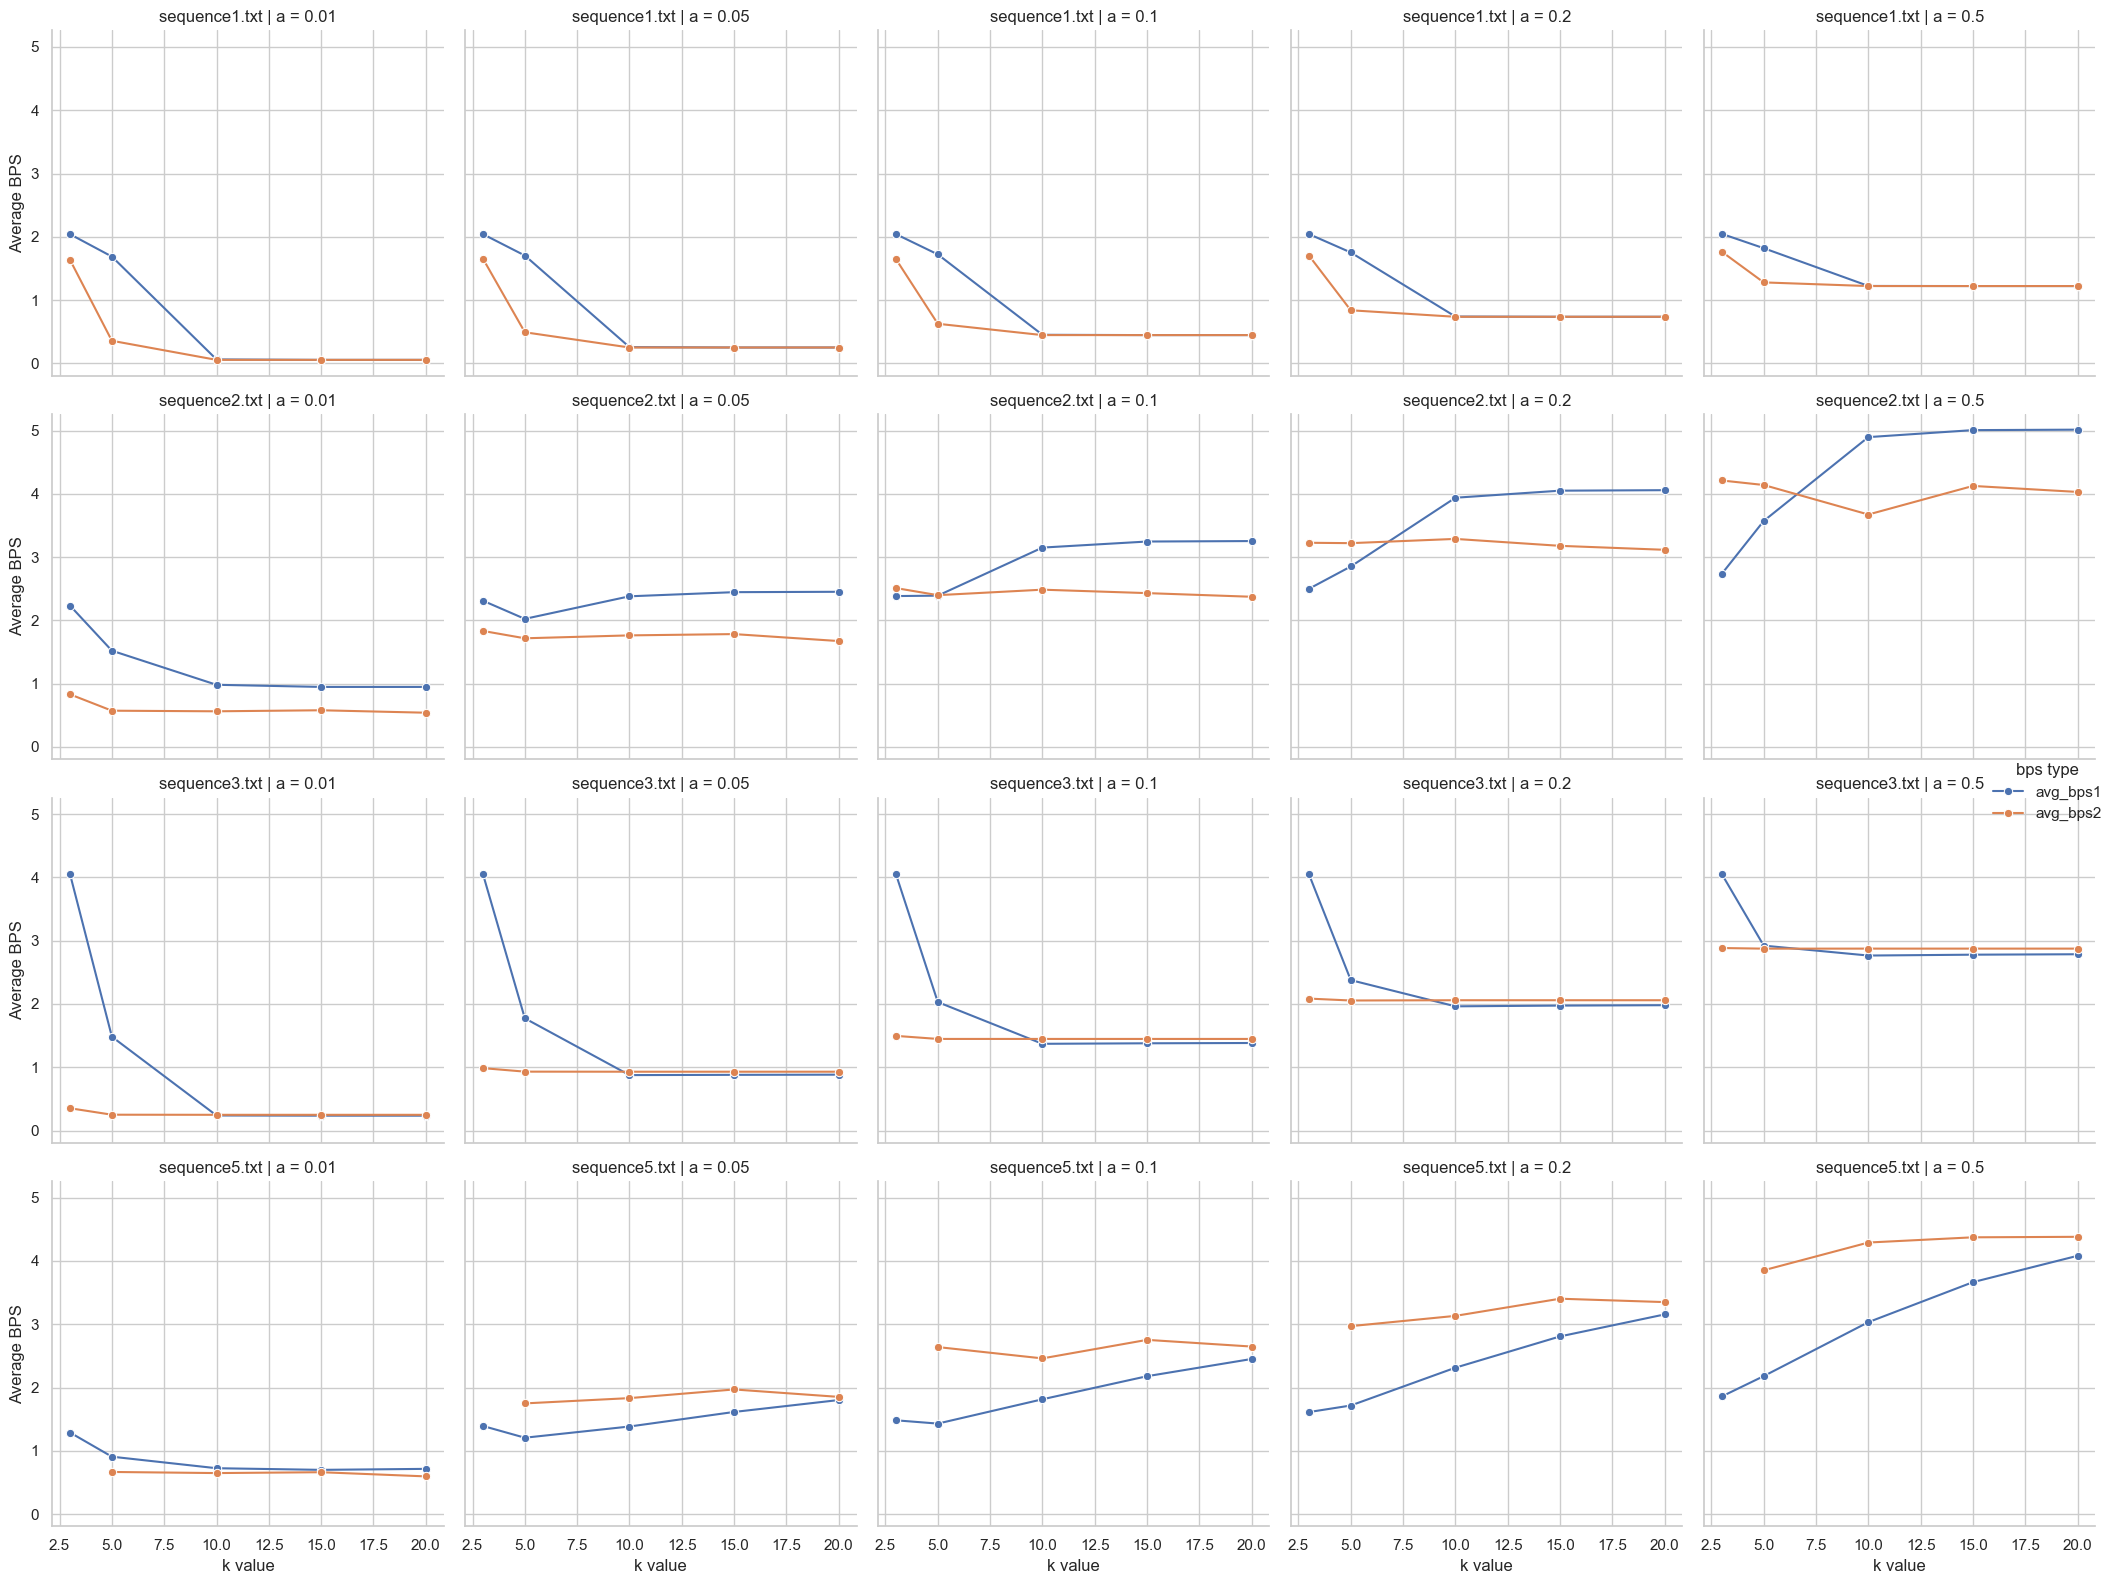

In [42]:
# Melt the DataFrame to have a long format for Seaborn plotting
melted_df = pd.melt(summary_df, id_vars=["input_file", "k", "a"],
                    value_vars=["avg_bps1", "avg_bps2"],
                    var_name="bps_type", value_name="avg_bps")

# Set a Seaborn theme for a clean look
sns.set_theme(style="whitegrid")

# Create a FacetGrid with rows as different sequences and columns as different a values.
g = sns.FacetGrid(melted_df, row="input_file", col="a", height=4, sharex=True, sharey=True, hue="bps_type")
g.map(sns.lineplot, "k", "avg_bps", marker="o")
g.add_legend(title="bps type")
g.set_axis_labels("k value", "Average BPS")
g.set_titles("{row_name} | a = {col_name}")
plt.tight_layout()
plt.show()